### Create figures showing OpenNeuro usage

In [7]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

datadir = '../data/openneuro'
figdir = '../figures'


In [8]:
# load and process metadata

metadata = pd.read_csv(os.path.join(datadir, 'metadata_06172021.csv'), skiprows=1)
metadata['Dataset made public (MM/DD/YYYY)'] = pd.to_datetime(metadata['Dataset made public (MM/DD/YYYY)'])
data_paper_dois = metadata['DOI of paper associated with DS (from submitter lab)'].unique()
print(f'{data_paper_dois.shape[0]} DOIs associated with dataset (from submitter)')

user_paper_dois = metadata['DOI of paper because DS on OpenNeuro'].unique()
print(f'{user_paper_dois.shape[0]} DOIs associated with dataset (from user)')

df_sorted = metadata.sort_values('Dataset made public (MM/DD/YYYY)')
df_sorted['ones'] = 1
df_sorted['cumulative'] = df_sorted['ones'].cumsum()
df_sorted['cumulative_subjects'] = df_sorted['# of subjects'].cumsum()



371 DOIs associated with dataset (from submitter)
29 DOIs associated with dataset (from user)


In [5]:
# load and process usage data
usage_data = pd.read_csv(os.path.join(datadir, 'users.csv'))
usage_data['Date'] = pd.to_datetime(usage_data['Month of Year'], format='%b %Y')
usage_data = usage_data.drop('Month of Year', axis=1).set_index('Date')

download_data = pd.read_csv(os.path.join(datadir, 'web_downloads.csv'))
#download_data = download_data.set_index('Year Month')
download_data['Date'] = pd.to_datetime(download_data['Year Month'], format='%b %Y')
download_data = download_data.drop('Year Month', axis=1)
download_data = download_data.set_index('Date')

download_gb_data = pd.read_csv(os.path.join(datadir, 'gb_downloaded.csv'))
download_gb_data = download_gb_data.groupby('Year Month').sum()
download_gb_data['TB downloaded'] = download_gb_data['GB downloaded'] / 1000
download_gb_data['Date'] = pd.to_datetime(download_gb_data.index, format='%b %Y')
download_gb_data = download_gb_data.set_index('Date')

alldata = download_data.join(download_gb_data, how='inner').join(usage_data, how='inner')
alldata = alldata.reset_index()
print(f'mean monthly download volume: {alldata.iloc[17:,3].mean()} TB')


mean monthly download volume: 34.98315232019675 TB


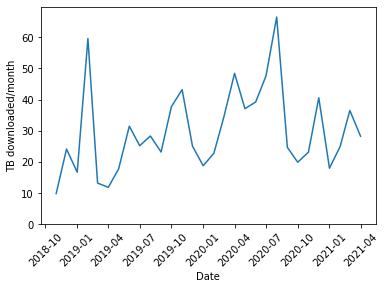

In [9]:
p = sns.lineplot(x='Date', y='TB downloaded', data=alldata)
plt.xticks(rotation=45)
plt.ylim([0, alldata['TB downloaded'].max()*1.05])
plt.ylabel('TB downloaded/month')

plt.savefig(os.path.join(figdir, 'TB_downloaded.png'))

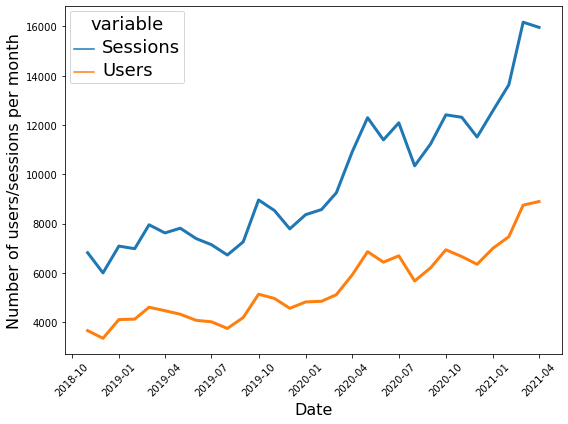

In [10]:
plt.figure(figsize=(8,6))
# plot sessions/users
userdata = alldata[['Date', 'Sessions', 'Users']]
userdata_long = pd.melt(userdata, id_vars='Date')
p = sns.lineplot(x='Date', y='value', hue='variable', data=userdata_long, linewidth=3)
plt.xticks(rotation=45)
plt.ylabel('Number of users/sessions per month', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.setp(plt.gca().get_legend().get_texts(), fontsize='18') # for legend text
plt.setp(plt.gca().get_legend().get_title(), fontsize='18') # for legend title

plt.tight_layout()
plt.savefig(os.path.join(figdir, 'sessions_users.png'))


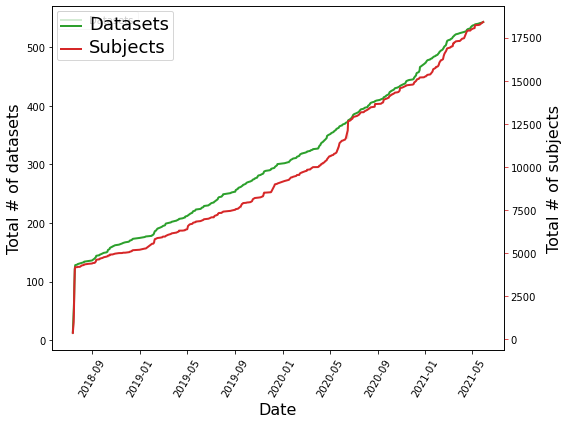

In [11]:
# plot datasets

fig, ax1 = plt.subplots(figsize=(8,6))
color = 'tab:green'
ax1.set_xlabel('Date', fontsize=16)
ax1.set_ylabel('Total # of datasets', fontsize=16) #, color=color)
ax1 = sns.lineplot(x='Dataset made public (MM/DD/YYYY)', y='cumulative', 
                    data=df_sorted, color=color, label='Datasets', linewidth=2)
ax1.tick_params(axis='y')
plt.xticks(rotation=60)
#ax1.legend()

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Total # of subjects', fontsize=16) #, color=color)
ax2 = sns.lineplot(x='Dataset made public (MM/DD/YYYY)', y='cumulative_subjects',
                   data=df_sorted, color=color, label='Subjects', linewidth=2)
ax2.tick_params(axis='y', color=color)
#ax2.legend(loc=1)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
plt.setp(ax2.get_legend().get_texts(), fontsize='18') # for legend text

plt.tight_layout()
plt.savefig(os.path.join(figdir, 'datasets_subjects.png'))